# Outlier Detection in Financial Data Using the Mahalanobis Distance

By Seth Lindokken

## Goal

We wish to illustrate the usefulness of the Mahalanobis distance for detecting outliers.

## Summary

Outliers are observations in a dataset that fall well outside of general trends. Proper detection and analysis of outliers can go a long way toward understanding one's data and constructing an effective and accurate model.

As fate would have it, outliers come in all shapes and sizes, and different types of data may require different methods for outlier detection. In a situation where the data consist of variables having bell-shaped distributions, the Mahalanobis distance is a particularly effective metric for determining how far away an observation is from the rest of the data.

In this note we will explore the Mahalanobis distance in two settings. We begin by testing it out on some simulated data. Then, for our main application, we will use it to identify various kinds of outliers in financial data.

## References

* A. Rencher and G. Schaalje. [Linear Models in Statistics](https://www.amazon.com/Linear-Models-Statistics-Alvin-Rencher/dp/0471754986). Wiley-Interscience. 2008.
* P.J. Rousseeuw and K. Van Driessen. [A Fast Algorithm for the Minimum Covariance Determinant Estimator](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.45.5870&rep=rep1&type=pdf). Technometrics. 1999.

## Import the Libraries

In [1]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.covariance import MinCovDet
%matplotlib inline

## The Mahalanobis Distance on Simulated Data

To get a flavor for the Mahalanobis distance, we begin by working with some simulated data. 

First, we use numpy to generate a dataset with two variables that are highly correlated.

In [2]:
corr = np.array([[1,0.9],[0.9,1]])
mean = np.array([0,0])
np.random.seed(1)
x,y = np.random.multivariate_normal(mean,corr,size=10000).T
data = pd.DataFrame(data=[x,y]).T
data.columns = ['x','y']
data.head()

,x,y
0,-1.446423,-1.720009
1,0.754721,0.274875
2,-0.328855,-1.358135
3,-1.530421,-1.870843
4,-0.255200,-0.366722


Text(0.5,1,'Distribution')

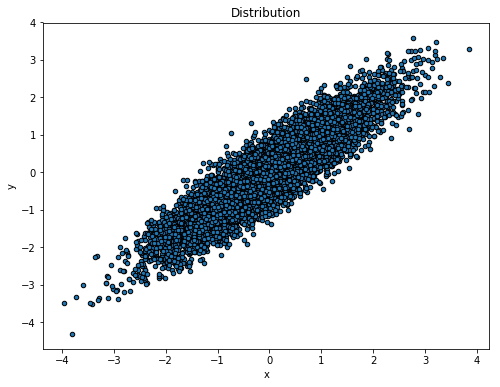

In [3]:
data.plot.scatter(x='x', y='y', edgecolors='black', figsize=(8, 6))
plt.title('Distribution')

### Adding Outliers

Next, we add two observations to our sample that will very clearly be outliers. Note that in each case, neither the $x$-value nor the $y$-value alone would necessarily raise any "outlier alarms."

Text(0.5,1,'Distribution with Outliers')

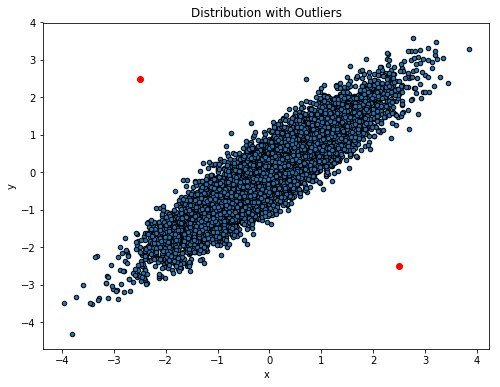

In [4]:
top_left = pd.DataFrame([[-2.5,2.5]],columns=['x','y'])
bottom_right = pd.DataFrame([[2.5,-2.5]],columns=['x','y'])
data = data.append(top_left,ignore_index=True)
data = data.append(bottom_right,ignore_index=True)

data.plot.scatter(x='x', y='y',
                     edgecolors='black', figsize=(8, 6))
plt.scatter(x=data.iloc[-2][0], y=data.iloc[-2][1], c='red', marker='o')
plt.scatter(x=data.iloc[-1][0],y = data.iloc[-1][1], c='red', marker='o' )
plt.title('Distribution with Outliers')

### Computing the Mahalanobis Distance

At its core, the Mahalanobis distance between a data point and the mean of the data is simply an "adjustment" of the usual notion of distance that takes into account all of the correlations between the variables in the model.

To be precise, given a dataset with expected value $\boldsymbol{\mu}$, its covariance matrix $\Sigma$, and an observation $\boldsymbol{x}$, the Mahalanobis distance from $\boldsymbol{x}$ to $\boldsymbol{\mu}$ is given by

\begin{align*}
d_{\text{Mah}}(\boldsymbol{x},\boldsymbol{\mu}) = \sqrt{(\boldsymbol{x} - \boldsymbol{\mu})^{T}\Sigma^{-1}(\boldsymbol{x}-\boldsymbol{\mu})}
\end{align*}

**Note:** Technically speaking, we won't be using the "pure" Mahalanobis distance. Rather, we will replace the usual mean/covariance matrices with those coming from the Minimum Covariance Determinant estimator, which is robust to outliers. For details, see [A Fast Algorithm for the Minimum Covariance Determinant Estimator](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.45.5870&rep=rep1&type=pdf) and/or the relevant sklearn documentation. If you are curious about what's going on with the matrix algebra, see [Linear Models in Statistics](https://www.amazon.com/Linear-Models-Statistics-Alvin-Rencher/dp/0471754986) (among many others).

In [5]:
mcd = MinCovDet(assume_centered=True, random_state=42)
cov = mcd.fit(data)
distances = pd.DataFrame(cov.dist_,index=data.index,columns=['Mahalanobis Distance'])
results = pd.concat([data,distances],axis=1)

In [6]:
results.describe()

,x,y,Mahalanobis Distance
count,10002.000000,10002.000000,10002.000000
mean,-0.017543,-0.016843,2.260924
std,1.001855,1.008834,2.998824
min,-3.969183,-4.312485,0.000304
25%,-0.706413,-0.696666,0.643330
50%,-0.023501,-0.019023,1.542534
75%,0.664203,0.662309,3.088192
max,3.841802,3.589695,143.160659


In [7]:
results.sort_values(by='Mahalanobis Distance',ascending=False).head()

,x,y,Mahalanobis Distance
10001,2.500000,-2.500000,143.160659
10000,-2.500000,2.500000,143.160659
282,0.710818,2.481159,20.831795
7463,-3.812673,-4.312485,20.309292
3877,-0.744156,1.056706,18.596105


As expected, the two points with extremely large Mahalanobis distances were the two outliers we added in.

## The Mahalanobis Distance on Real Data

Now that we have a basic sense of the Mahalanobis distance, we will put it to work on real data.

Using the AlphaVantage API, we have collected information on daily returns for over 400 companies listed on the S&P 500 (broken down by GICS Sector). After reading in the relevant files, we compile the data into one DataFrame.

In [8]:
equity_data = glob.glob('*prices.csv')
equity_data

['commservices_equity_prices.csv',
 'consdisc_equity_prices.csv',
 'constaples_equity_prices.csv',
 'energy_equity_prices.csv',
 'financials_equity_prices.csv',
 'healthcare_equity_prices.csv',
 'industrials_equity_prices.csv',
 'infotech_equity_prices.csv',
 'materials_equity_prices.csv',
 'realestate_equity_prices.csv',
 'utilities_equity_prices.csv']

In [9]:
sectors = ['Communication Services','Consumer Discretionary','Consumer Staples','Energy',
          'Financials','Health Care','Industrials','Information Technology','Materials','Real Estate','Utilities']

for i in range(len(equity_data)):
    equity_data[i] = pd.read_csv(equity_data[i],index_col=0).loc['2007-01-01':'2018-12-31'].dropna(axis=1)
    equity_data[i][str(sectors[i])] = equity_data[i].mean(axis=1)
    
equities = pd.concat(equity_data,axis=1,keys=sectors)
equities = equities.pct_change()
equities = equities[1:]
equities.columns.names = ['Sector','Ticker']

In [10]:
equities.head()

Sector     Communication Services                                          \
Ticker                       ATVI     GOOGL         T       CBS       CTL   
2007-01-04               0.008159  0.033512 -0.012876 -0.008544 -0.000686   
2007-01-05              -0.005780  0.008132 -0.015652 -0.014044 -0.001144   
2007-01-08              -0.000581 -0.007410 -0.004417  0.005180 -0.005727   
2007-01-09              -0.000582  0.003970  0.003845 -0.005153 -0.004378   
2007-01-10               0.020373  0.008157  0.002652  0.008741  0.002546   

Sector                                                          ...     \
Ticker         CMCSA     DISCA      DISH        EA       IPG    ...      
2007-01-04  0.009142 -0.004245 -0.004170  0.051322  0.006536    ...      
2007-01-05 -0.011614 -0.006699  0.004187 -0.011179 -0.003247    ...      
2007-01-08 -0.001880  0.019007  0.015116 -0.003580 -0.003257    ...      
2007-01-09  0.006357 -0.006619  0.012323 -0.003404  0.009804    ...      
2007-01-10  0.003978  0.007268  0.002536  0.018596  0.033981    ...      

Sector     Utilities                                                    \
Ticker            NI       NRG       PNW       PPL       PEG       SRE   
2007-01-04 -0.003708 -0.007702  0.001747 -0.004950 -0.003150 -0.008807   
2007-01-05 -0.025227 -0.016065 -0.022093 -0.017413 -0.022570 -0.019193   
2007-01-08 -0.001697  0.008072  0.003369 -0.002532  0.000462 -0.003624   
2007-01-09  0.002975  0.008007 -0.009876  0.004230  0.021234  0.011638   
2007-01-10  0.006780  0.010652  0.002992 -0.003370 -0.005575  0.000000   

Sector                                              
Ticker            SO       WEC       XEL Utilities  
2007-01-04  0.000541  0.000209  0.000854 -0.002030  
2007-01-05 -0.015135 -0.020651 -0.020043 -0.019625  
2007-01-08  0.002744 -0.009159  0.000000 -0.002241  
2007-01-09  0.002737 -0.003009 -0.000435  0.001026  
2007-01-10 -0.001910  0.000431  0.005224  0.001393  

[5 rows x 442 columns]

### Getting Sector-Level Data

Rather than work with individual equities, we will study daily returns by sector:

In [11]:
by_sect = pd.concat([equities[sector].iloc[:,-1] for sector in sectors],axis=1)
by_sect.head()

,Communication Services,Consumer Discretionary,Consumer Staples,Energy,Financials,Health Care,Industrials,Information Technology,Materials,Real Estate,Utilities
2007-01-04,0.017403,0.002284,-0.002619,-0.018494,-0.003742,0.006928,-0.000743,0.018765,-0.005866,0.002043,-0.002030
2007-01-05,0.000583,-0.006751,-0.007156,0.009172,-0.007332,-0.005116,-0.008872,-0.011339,-0.009601,-0.015604,-0.019625
2007-01-08,-0.003578,0.000995,0.000159,0.006463,0.004471,0.001692,0.002798,0.004508,-0.000123,0.000401,-0.002241
2007-01-09,0.003096,0.007574,0.002812,-0.011614,0.008665,-0.003040,0.001469,0.005813,0.003605,0.012609,0.001026
2007-01-10,0.008356,0.004677,0.005458,-0.016701,0.006055,0.003309,0.004813,0.008643,0.004145,0.013867,0.001393


In [12]:
by_sect.describe()

,Communication Services,Consumer Discretionary,Consumer Staples,Energy,Financials,Health Care,Industrials,Information Technology,Materials,Real Estate,Utilities
count,3019.000000,3019.000000,3019.000000,3019.000000,3019.000000,3019.000000,3019.000000,3019.000000,3019.000000,3019.000000,3019.000000
mean,0.000374,0.000487,0.000229,0.000178,0.000047,0.000443,0.000339,0.000410,0.000309,0.000323,0.000188
std,0.016721,0.014371,0.009183,0.020013,0.018373,0.012123,0.014161,0.014602,0.016000,0.019651,0.011687
min,-0.306558,-0.094255,-0.071419,-0.163603,-0.562817,-0.080714,-0.098423,-0.165101,-0.116724,-0.181230,-0.077324
25%,-0.005768,-0.005912,-0.004037,-0.008782,-0.006097,-0.005055,-0.005772,-0.005685,-0.006301,-0.006508,-0.005150
50%,0.001004,0.000952,0.000594,0.000109,0.000528,0.000963,0.000813,0.001037,0.001002,0.000612,0.000843
75%,0.007591,0.007530,0.005075,0.010170,0.006944,0.006915,0.007023,0.007441,0.007899,0.007489,0.006221
max,0.143302,0.100621,0.077628,0.194420,0.161846,0.118150,0.108961,0.113386,0.118900,0.174965,0.131077


It's worth verifying that we are in fact working with variables that have bell-shaped distributions (in order for the Mahalanobis distance to be the most useful). We show one example below:

C:\Users\lindset\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


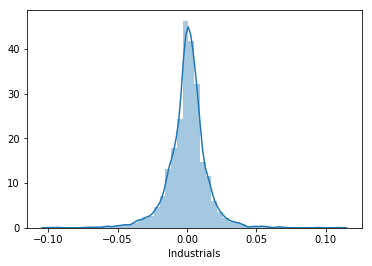

In [13]:
sns.distplot(by_sect['Industrials'])

### Computing the Mahalanobis Distance

Next, we repeat the procedure from before and calculate the Mahalanobis distance for each observation.

In [14]:
cov_matrix = by_sect.cov()
mcd = MinCovDet(assume_centered=True, random_state=42)
cov = mcd.fit(by_sect)
distances = pd.DataFrame(cov.dist_,index=by_sect.index,columns=['Mahalanobis Distance'])

In [15]:
distances.describe()

,Mahalanobis Distance
count,3019.000000
mean,28.399802
std,212.322175
min,0.789338
25%,7.235414
50%,12.290762
75%,21.441672
max,10864.162450


C:\Users\lindset\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


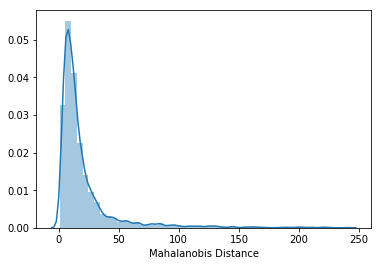

In [16]:
sns.distplot(distances[distances['Mahalanobis Distance'] < 250]['Mahalanobis Distance'])

Above, we show the distribution of Mahalanobis distances that were less than 250.

Below, we list out the Mahalanobis distances that were at least 250, together with the corresponding date.

In [17]:
distances[distances['Mahalanobis Distance'] >= 250].sort_values(by='Mahalanobis Distance',ascending=False)

,Mahalanobis Distance
2010-01-21,10864.162450
2015-07-15,2643.120960
2014-04-03,1901.961609
2014-01-22,1564.159415
2014-06-09,1089.654146
2015-06-18,633.551711
2009-03-10,604.931888
2008-10-13,597.414571
2008-11-24,532.575130
2008-10-10,517.395788


## An Analysis of (Two) Outliers

### Berkshire Hathaway Stock Split

Ahh yes... I think it goes without saying that everyone remembers exactly where they were on January 21, 2010 when the stock market shot way... up? Or was it down? Either way there was ***clearly*** some sort of tectonic shift in the market. Or was there?

It turns out that it was not a banner day for the stock market. The S&P 500 lost about 1%, in fact. But that was not the driving force behind the story. Berkshire Hathaway (Class B) had a 50-for-1 stock split, which made it appear in the data as if the stock dropped 98%. This in turn led to an apparent 56% loss in the Financials sector, which makes the day look *much* worse than it actually was.

We leave it to the interested reader to verify that the next five highest Mahalanobis distances also correspond to various stock splits.

In [18]:
by_sect.loc['2010-01-21']

Communication Services   -0.002600
Consumer Discretionary   -0.007552
Consumer Staples         -0.006863
Energy                   -0.016308
Financials               -0.562817
Health Care              -0.015893
Industrials              -0.019321
Information Technology   -0.011863
Materials                -0.030997
Real Estate              -0.025148
Utilities                -0.014231
Name: 2010-01-21, dtype: float64

In [19]:
equities.loc['2010-01-21']['Financials']['BRK.B']

-0.9790794016110472

### The Recovery Begins

The highest Mahalanobis distance corresponding to a truly remarkable day for the S&P 500 comes on March 10, 2009. This day essentially marks the beginning of the recovery following the Great Recession. In particular, the S&P 500 gained back 6.4%.

By and large, any high Mahalanobis distance from 2008 or 2009 did in fact correspond to a volatile day for the S&P 500. Once more, we leave it to the interested reader to explore the causes of these outliers.

In [20]:
by_sect.loc['2009-03-10']

Communication Services    0.055823
Consumer Discretionary    0.076426
Consumer Staples          0.022227
Energy                    0.062039
Financials                0.161846
Health Care               0.040897
Industrials               0.065428
Information Technology    0.064657
Materials                 0.061507
Real Estate               0.140074
Utilities                 0.024817
Name: 2009-03-10, dtype: float64

## Conclusion

We have seen that the Mahalanobis distance can be extraordinarily useful for outlier detection, both in simulated and real data. However, we have also seen that these distances alone can't necessarily tell you the ***reason*** your outlier is an outlier. As per usual, we are left with no choice but to conclude that data *analysis* does actually require some *analysis*!